# LMS distortion



The following is a summary of the steps that were taken to apply the CRIRES+ data reduction to simulation the METIS LMS IFU.
* ScopeSim runs
* Insert data into CRIRES frames
* Order tracing
* Tilt determination
* Extracting 1D spectra
* Assigning Wavelength and spatial scale to pixels in 2D spectra

## ScopeSim
As of april 2022, when these simulations were carried out, the release-version of the simulator did not support the IFU mode of METIS. Therefore a development version of the LMS-branch was istalled, after instructions from the team. The mode was set such that the 
The scipt that creates the frame with the sky spectrum is called `lms_sky.py` and does very little besides calling the simulator with default arguments, and istructing it to set the central wavelength of the spectrograph to arbitrary 3.55micon.
In addition, it retrieves the wavelength scale from one of the slices, in order to later ingest it into the CRIRES-pipeline.

## CRIRES DRS
The upgraded CRIRES is a cross-dispersed echelle slit-spectrograph for the near-infrared bands YJHKLM. It uses three of the same HAWAII2RG detectors that the METIS will use four of. The fact that CRIRES images several spectral orders while METIS does slices of spatial regions, is not no hindrance to applying the same methods for finding the location and shape of each order/slice in the detector grid, and to determine the orientation of the "slit".

The CRIRES DRS is a standard ESO-pipeline that was developped from scratch for the upgraded instrument and is in operation since late 2021. It can be installed from the usual sources for ESO pipelines on their website, no particular version is needed for this exercise since the basic algorithms have not changed.

ScopeSim produces frames for all four of the LMS detectors. Simply ignoring the fourth, the pixel values were copied into a raw frame CRIRES, thus preserving its headers and replacing the data.

## Order tracing
By "trace" we mean the polynomial in detector coordinates (x,y) that describes the mid-line of the spectral order. This is done by smoothing and thresholding the sky frame (which has enough continuum) in order to distinguish in-order from inter-order pixels. Continuous clusters of in-order pixels are then fitted with a second-degree polynomial.
The command executed was

    # esorex cr2res_util_trace trace_sky.sof
    
, where `trace_sky.sof` contains only one line, pretending the sky frame is a FLAT (which is what is usually used for tracing)

    CIRES_sky.fits FLAT
    
The output file is `CIRES_sky_tw.fits` which is a table that now has the traces for each slice. In addition to the mid-line, it also has the polynomials for the upper and lower edges of each slice.

## Slit tilt
Next up is measuring the orientation of the "slit" in each slice, i.e. the tilt of spectral lines w.r.t. the detector columns. Using the trace from the previous step, each slice gets rectified by shifting columns by integer values according to the trace.
Then a peak-finder is run on each row to find spectral lines, which are then fitted with Gaussians to determine their line centers. Comparing how the line-centers change with detector rows, allows us to fit the slit tilt as a polynomyal P(y). In order to reject outliers and ensure a smooth change in the tilt, the *coefficients* of the tilt polynomials are then each fit as P(x).
These coefficients are saved in a new FITS-table, called 

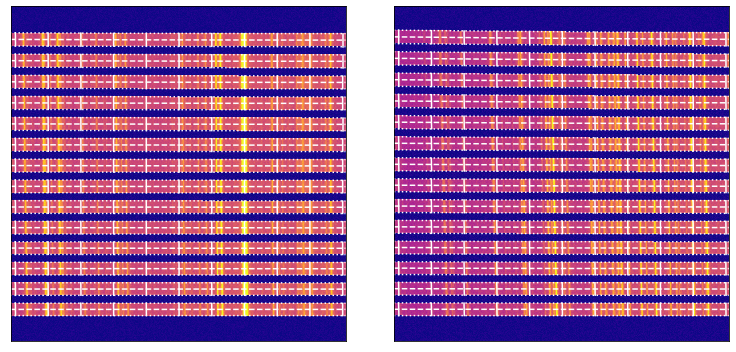

In [3]:
%run show_trace_curv.py CIRES_sky_tw_tw.fits CIRES_sky.fits

In [4]:
from pylab import *
from astropy.io.fits import open as fo

In [6]:
tilts = fo('CIRES_sky_tw_tw.fits')[1].data['SlitPolyB']
tilts

array([[-1.45030918e-02,  4.97644175e-06, -8.81093015e-10],
       [-1.71465266e-02,  1.19526702e-05, -4.11230539e-09],
       [-1.60470680e-02,  9.62834066e-06, -2.46179182e-09],
       [-1.56843290e-02,  1.04739179e-05, -3.39557250e-09],
       [-9.89049691e-03, -7.80064422e-07,  1.55907143e-09],
       [-1.37041189e-02,  7.36109573e-06, -1.76092183e-09],
       [-1.21335419e-02,  3.73431498e-06,  3.62338925e-10],
       [-9.88651568e-03,  1.90595104e-06,  9.70922842e-10],
       [-1.25626738e-02,  9.42000943e-06, -3.06478176e-09],
       [-1.23701034e-02,  4.81279417e-06,  6.75878571e-10],
       [-1.30267035e-02,  9.46268944e-06, -2.61068479e-09],
       [-9.47728454e-03,  3.20871517e-06,  1.27630431e-09],
       [-1.29999200e-02,  1.02179873e-05, -1.89150864e-09],
       [-1.04358752e-02,  2.52729614e-06,  1.30881039e-09]])

When we evaluate one of the polynomials at the detector edges and center, we find that the slit angle varies between 0.5 and 0.9 degrees.

In [13]:
dx=polyval(tilts[3][::-1],[1,1024,2048]) 
dx

array([-0.01567386, -0.00851955, -0.00847581])

In [14]:
degrees(arctan(dx)) # Tilt angles

array([-0.89797241, -0.48812261, -0.48561642])

In [15]:
dx*80 # pixel difference between top and bottom of a slice, ~80 high

array([-1.25390868, -0.68156423, -0.67806467])